In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LogNorm
from collections import defaultdict

In [20]:
cluster_dir = './drop_model_movement'
rect_csv = 'floor_overlay_labels.csv'
pix_to_m = 0.003175


In [21]:
T = pd.read_csv(os.path.join(cluster_dir, rect_csv))

In [23]:
cluster_pattern = 'cluster_*.csv'
csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))

In [8]:
def floor_rects_metric_inline_ir(csvfile='floor_overlay_labels.csv', show_text=True):

    """Maps floorplan"""
    pix_to_m = 0.003175

    # Read CSV file
    T = pd.read_csv(csvfile)

    # Create plot
    fig, ax = plt.subplots()

    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m

        rect = plt.Rectangle((x, y), w, h, edgecolor=[0.5, 0.5, 0.5], facecolor='none', linewidth=1)
        ax.add_patch(rect)

        if show_text:
            ax.text(x, y + h + 0.05, row['name'], color='black', fontsize=8,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_aspect('equal')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    plt.title('Floor Overlay Rectangles')
    ax.autoscale_view()
    plt.tight_layout()

    plt.show()

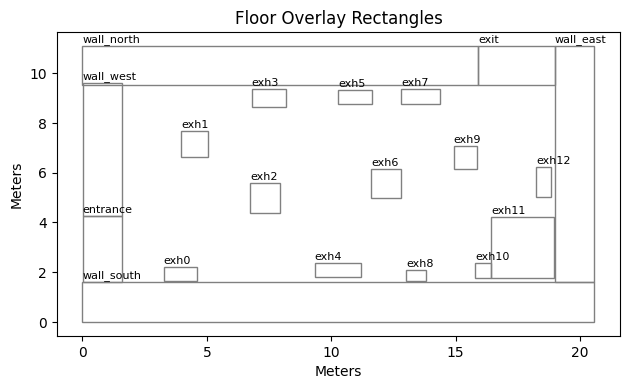

In [9]:
floor_rects_metric_inline_ir('/Users/iuliarusu/Documents/museum/drop_model_movement/floor_overlay_labels.csv')

In [12]:


def floorplan_trajectories_ir(
    rect_csv='floor_overlay_labels.csv',
    cluster_pattern='cluster_*.csv',
    cluster_dir='.',
    filter_files= None,
    plot_separate=True
):
    pix_to_m = 0.003175

    # ── Load rectangle overlay CSV ──
    rect_path = os.path.join(cluster_dir, rect_csv)
    T = pd.read_csv(rect_path)

    if filter_files:
        wanted = {os.path.basename(f) for f in filter_files}
        csv_files = [f for f in all_files if os.path.basename(f) in wanted]
    else:
        csv_files = all_files

    # ── Load all cluster CSVs ──
    csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))
    num_files = len(csv_files)
    colors = cm.get_cmap('tab20', num_files)  # A colormap with enough unique colors

    # ── Plot floorplan with overlaid trajectories ──
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m
        rect = plt.Rectangle((x, y), w, h, edgecolor='gray', facecolor='none', linewidth=1)
        ax1.add_patch(rect)
        ax1.text(x, y + h + 0.05, row['name'], fontsize=8, color='black', va='bottom', ha='left')

    for i, file in enumerate(csv_files):
        data = pd.read_csv(file)
        if data.shape[1] >= 3:
            x = data.iloc[:, 1] * pix_to_m  # Column 2 in MATLAB → index 1
            y = data.iloc[:, 2] * pix_to_m  # Column 3 in MATLAB → index 2
            ax1.plot(x, y, '.', color=colors(i), linewidth=0.5, markersize=1)

    ax1.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
    ax1.set_ylim(0, 3500 * pix_to_m)
    ax1.set_aspect('equal')
    ax1.set_title("Floor Plan and Trajectories in Meters")
    ax1.set_xlabel("X (m)")
    ax1.set_ylabel("Y (m)")
    plt.tight_layout()
    plt.show()

    # ── Plot each trajectory separately ──
    if plot_separate:
        cols = 4
        rows = int(np.ceil(num_files / cols))
        fig2, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        for i, file in enumerate(csv_files):
            ax = axes[i]
            data = pd.read_csv(file)
            if data.shape[1] >= 3:
                x = data.iloc[:, 1] * pix_to_m
                y = data.iloc[:, 2] * pix_to_m
                ax.plot(x, y, '.', color=colors(i), linewidth=0.5, markersize=1)
                ax.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
                ax.set_ylim(0, 3500 * pix_to_m)
                ax.set_title(f"cluster {os.path.basename(file)[8:11]}", fontsize=7)

        # Hide unused subplots
        for i in range(num_files, len(axes)):
            fig2.delaxes(axes[i])

        plt.tight_layout()
        plt.show()


In [ ]:
floorplan_trajectories_ir()

In [17]:
def floorplan_trajectories_ir(
    rect_csv='floor_overlay_labels.csv',
    cluster_pattern='cluster_*.csv',
    cluster_dir='.',
    plot_separate=True,
    filter_files=None          # list of filenames (e.g. ['cluster_005.csv'])
):
    """
    Draw the floor plan and overlay selected trajectory CSVs.

    Parameters
    ----------
    rect_csv : str
        CSV containing rectangle definitions (x, y, width, height, name).
    cluster_pattern : str
        Glob pattern for trajectory CSVs (default 'cluster_*.csv').
    cluster_dir : str
        Directory where CSVs live.
    plot_separate : bool
        If True, make a subplot grid of individual traces.
    filter_files : list[str] | None
        If provided, only plot these filenames (basename match).
    """
    pix_to_m = 0.003175

    # ── read floor rectangles ────────────────────────────────────────────
    rect_path = os.path.join(cluster_dir, rect_csv)
    T = pd.read_csv(rect_path)

    # ── gather trajectory files ─────────────────────────────────────────-
    all_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))
    if filter_files:
        wanted = {os.path.basename(f) for f in filter_files}
        csv_files = [f for f in all_files if os.path.basename(f) in wanted]
    else:
        csv_files = all_files

    n_files = len(csv_files)
    colors = cm.get_cmap('tab20', n_files)

    # ── figure 1: floor plan + selected traces ───────────────────────────
    fig1, ax1 = plt.subplots(figsize=(8, 6))

    # draw rectangles
    for _, row in T.iterrows():
        x, y = row['x'] * pix_to_m, row['y'] * pix_to_m
        w, h = row['width'] * pix_to_m, row['height'] * pix_to_m
        ax1.add_patch(plt.Rectangle((x, y), w, h,
                                    edgecolor='gray', facecolor='none', lw=1))
        ax1.text(x, y + h + 0.05, row['name'],
                 fontsize=8, color='black', va='bottom', ha='left')

    # draw trajectories
    for i, f in enumerate(csv_files):
        data = pd.read_csv(f)
        x = data.iloc[:, 1] * pix_to_m
        y = data.iloc[:, 2] * pix_to_m
        ax1.plot(x, y, '.', color=colors(i), lw=0.5, ms=1,
                 label=os.path.basename(f))

    ax1.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
    ax1.set_ylim(0, 3500 * pix_to_m)
    ax1.set_aspect('equal')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Floor Plan and Selected Trajectories')
    ax1.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()
    plt.show()

    if plot_separate and n_files:
            cols = 4
            rows = int(np.ceil(n_files / cols))
            fig2, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
            axes = axes.flatten()

            for i, f in enumerate(csv_files):
                data = pd.read_csv(f)
                x = data.iloc[:, 1] * pix_to_m
                y = data.iloc[:, 2] * pix_to_m
                ax = axes[i]

                # draw floor rectangles on each subplot
                for _, row in T.iterrows():
                    rect_x = row['x'] * pix_to_m
                    rect_y = row['y'] * pix_to_m
                    rect_w = row['width'] * pix_to_m
                    rect_h = row['height'] * pix_to_m
                    ax.add_patch(plt.Rectangle(
                        (rect_x, rect_y), rect_w, rect_h,
                        edgecolor='gray', facecolor='none', lw=0.5))
                    ax.text(rect_x, rect_y + rect_h + 0.02, row['name'],
                            fontsize=5, color='black', va='bottom', ha='left')

                ax.plot(x, y, '.', color=colors(i), lw=0.5, ms=1)
                ax.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
                ax.set_ylim(0, 3500 * pix_to_m)
                ax.set_aspect('equal')
                ax.set_title(f"cluster {os.path.basename(f)[8:11]}", fontsize=7)

            # remove empty panels
            for j in range(i + 1, len(axes)):
                fig2.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_3494/1352664879.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_files)


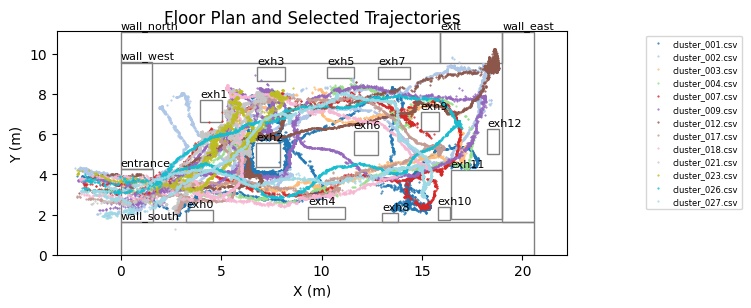

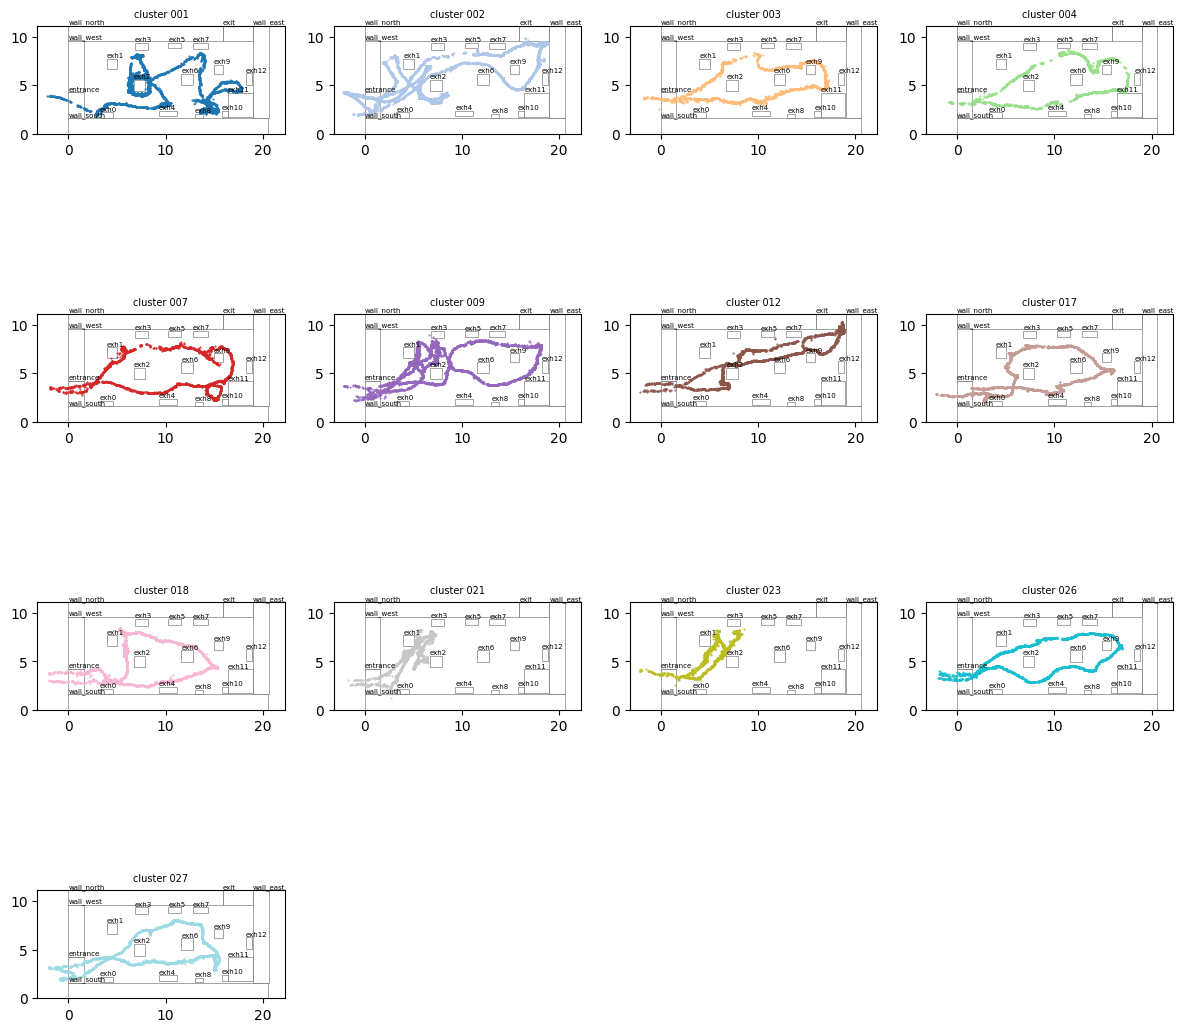

In [18]:
floorplan_trajectories_ir(cluster_dir='drop_model_movement')

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_3494/686472766.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_files)


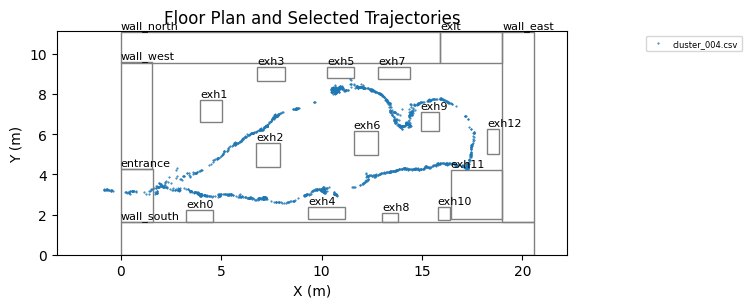

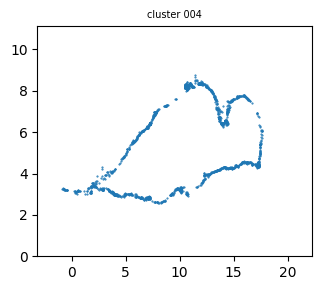

In [16]:
floorplan_trajectories_ir(
    cluster_dir='drop_model_movement',
    filter_files=['cluster_004.csv']
)

Divide the floor plan into state space


In [ ]:
def floor_rects_metric_inline_ir_statespace(csvfile='floor_overlay_labels.csv', show_text=True):

    """Maps floorplan"""
    pix_to_m = 0.003175

    # Read CSV file
    T = pd.read_csv(csvfile)

    # Create plot
    fig, ax = plt.subplots()

    states = []
    for _, row in T.iterrows():
        x = row['x'] * pix_to_m
        y = row['y'] * pix_to_m
        w = row['width'] * pix_to_m
        h = row['height'] * pix_to_m

        rect = plt.Rectangle((x, y), w, h, edgecolor=[0.5, 0.5, 0.5], facecolor='none', linewidth=1)
        

        ax.add_patch(rect)



        if show_text:
            ax.text(x, y + h + 0.05, row['name'], color='black', fontsize=8,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_aspect('equal')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    plt.title('Floor Overlay Rectangles')
    ax.autoscale_view()
    plt.tight_layout()

    plt.show()

In [ ]:
#museum traces with meandering

short = [21, 23]
mid = [3, 4, 26, 17, 18, 7, 27]
long = [1, 2, 9]

In [31]:
def plot_individual_heatmaps(csv_files, pix_to_m, T, binsize=0.2):
    """
    Plot one linger heatmap per individual trajectory (per CSV).
    """
    n = len(csv_files)
    cols = 4
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for i, f in enumerate(csv_files):
        data = pd.read_csv(f, header=None, names=["time", "x", "y"])
        x = data["x"] * pix_to_m
        y = data["y"] * pix_to_m

        xmin, xmax = -1.0, 7.0
        ymin, ymax = 0.0, 3.5
        xbins = np.arange(xmin, xmax, binsize)
        ybins = np.arange(ymin, ymax, binsize)
        heatmap, _, _ = np.histogram2d(x, y, bins=[xbins, ybins])

        ax = axes[i]
        extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='equal', cmap='hot')

        # draw floor rectangles
        for _, row in T.iterrows():
            rx, ry = row['x'] * pix_to_m, row['y'] * pix_to_m
            rw, rh = row['width'] * pix_to_m, row['height'] * pix_to_m
            ax.add_patch(plt.Rectangle((rx, ry), rw, rh, edgecolor='gray', facecolor='none', lw=0.5))

        ax.set_title(os.path.basename(f)[8:11], fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    # Remove any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [25]:
csv_files

['./drop_model_movement/cluster_001.csv',
 './drop_model_movement/cluster_002.csv',
 './drop_model_movement/cluster_003.csv',
 './drop_model_movement/cluster_004.csv',
 './drop_model_movement/cluster_007.csv',
 './drop_model_movement/cluster_009.csv',
 './drop_model_movement/cluster_012.csv',
 './drop_model_movement/cluster_017.csv',
 './drop_model_movement/cluster_018.csv',
 './drop_model_movement/cluster_021.csv',
 './drop_model_movement/cluster_023.csv',
 './drop_model_movement/cluster_026.csv',
 './drop_model_movement/cluster_027.csv']

In [53]:
def plot_individual_heatmaps_fixed(csv_files, pix_to_m, T, binsize=0.5, vmin=None, vmax=None):
    """
    Plot one heatmap per individual with fixed floor bounds and layout.
    """
    cols = 4
    rows = int(np.ceil(len(csv_files) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    # Fixed layout limits from working trace plot
    xlim = (-1000 * pix_to_m, 7000 * pix_to_m)
    ylim = (0, 3500 * pix_to_m)
    xbins = np.arange(xlim[0], xlim[1] + binsize, binsize)
    ybins = np.arange(ylim[0], ylim[1] + binsize, binsize)

    # Optional: find max value for consistent colormap scaling
    if vmin is None or vmax is None:
        all_counts = []
        for f in csv_files:
            data = pd.read_csv(f)
            x = data.iloc[:, 1] * pix_to_m
            y = data.iloc[:, 2] * pix_to_m
            h, _, _ = np.histogram2d(x, y, bins=[xbins, ybins])
            all_counts.append(h)
        global_hist = np.stack(all_counts).max(axis=0)
        vmax = global_hist.max()
        vmin = 0

    for i, f in enumerate(csv_files):
        data = pd.read_csv(f)
        x = data.iloc[:, 1] * pix_to_m
        y = data.iloc[:, 2] * pix_to_m

        heatmap, _, _ = np.histogram2d(x, y, bins=[xbins, ybins])

        ax = axes[i]
        extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='equal',
               cmap='hot', norm=LogNorm(vmin=1, vmax=vmax), interpolation='none')

        for _, row in T.iterrows():
            rx, ry = row['x'] * pix_to_m, row['y'] * pix_to_m
            rw, rh = row['width'] * pix_to_m, row['height'] * pix_to_m
            ax.add_patch(plt.Rectangle((rx, ry), rw, rh,
                                       edgecolor='gray', facecolor='none', lw=0.5))

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(os.path.basename(f)[8:11], fontsize=7)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Visit Count')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_3494/2347124719.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


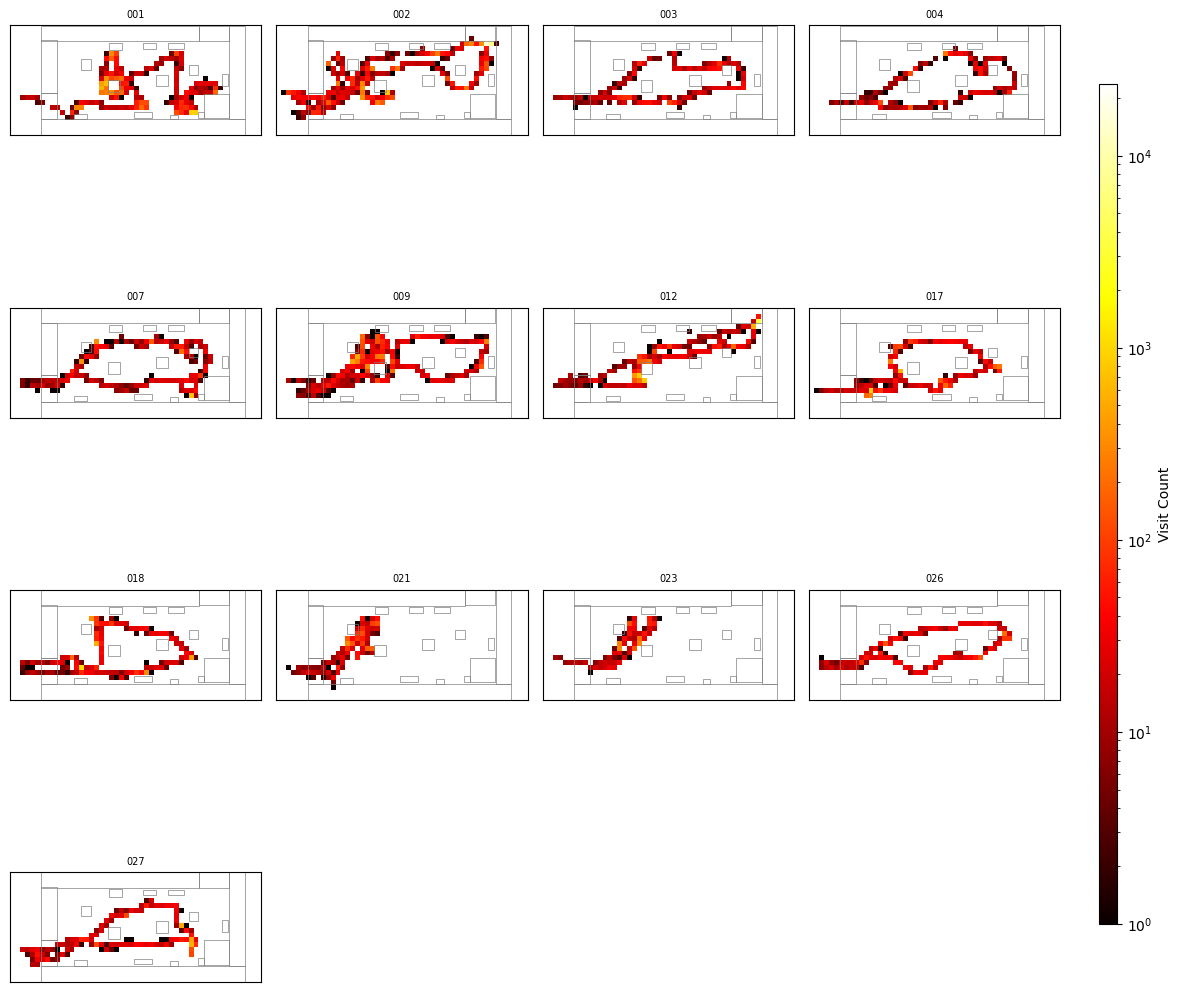

In [54]:
plot_individual_heatmaps_fixed(csv_files, pix_to_m, T)


In [36]:
def debug_heatmap_with_trace(csv_file, pix_to_m, T, binsize=0.2):
    data = pd.read_csv(csv_file)
    x = data.iloc[:, 1] * pix_to_m
    y = data.iloc[:, 2] * pix_to_m

    # Use same limits as your successful plots
    xlim = (-1000 * pix_to_m, 7000 * pix_to_m)
    ylim = (0, 3500 * pix_to_m)

    xbins = np.arange(xlim[0], xlim[1], binsize)
    ybins = np.arange(ylim[0], ylim[1], binsize)

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])

    fig, ax = plt.subplots(figsize=(8, 6))
    
    # IMPT: do NOT transpose
    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
    im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='equal', cmap='hot', interpolation='none')

    # Overlay original trace
    ax.plot(x, y, '.', color='white', alpha=0.3, markersize=1)

    # Overlay floorplan
    for _, row in T.iterrows():
        rx, ry = row['x'] * pix_to_m, row['y'] * pix_to_m
        rw, rh = row['width'] * pix_to_m, row['height'] * pix_to_m
        ax.add_patch(plt.Rectangle((rx, ry), rw, rh, edgecolor='gray', facecolor='none', lw=0.5))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("DEBUG: Heatmap + Raw Trace Overlay")
    plt.colorbar(im, ax=ax, label="Visit count")
    plt.tight_layout()
    plt.show()

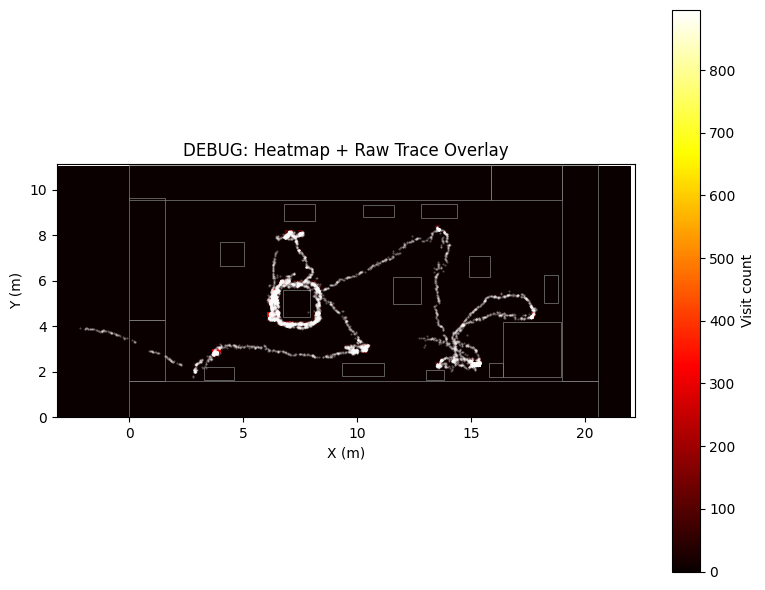

In [37]:
debug_heatmap_with_trace(csv_files[0], pix_to_m, T)

# compute walkable area, and divide it into state space

In [121]:
def compute_walkable_mask(rect_csv, pix_to_m=0.003175, resolution=0.05): #resolution in meters
    """
    Compute a binary mask (True = walkable) of the museum floor layout.

    Parameters
    ----------
    rect_csv : str
        CSV path with floorplan rectangles (x, y, width, height, name).
    pix_to_m : float
        Scaling factor from pixels to meters.
    resolution : float
        Size of each grid cell in meters.

    Returns
    -------
    walkable_mask : 2D np.array (bool)
        True where walkable, False where exhibit or wall.
    x_grid, y_grid : 2D np.arrays
        X and Y coordinate meshgrids (in meters).
    """
    # Read floorplan
    T = pd.read_csv(rect_csv)

    # Define canvas size from bounding box
    all_x = (T['x'] + T['width']) * pix_to_m
    all_y = (T['y'] + T['height']) * pix_to_m
    max_x = np.ceil(all_x.max())
    max_y = np.ceil(all_y.max())

    x_coords = np.arange(0, max_x, resolution)
    y_coords = np.arange(0, max_y, resolution)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    walkable_mask = np.ones_like(x_grid, dtype=bool)

    # Names to exclude
    exclude = ['exit', 'wall_north', 'wall_south', 'wall_west', 'wall_east'] + \
              [f"exh{i}" for i in range(13)]

    # Zero out each excluded rectangle
    for _, row in T.iterrows():
        if row['name'] in exclude:
            rx = row['x'] * pix_to_m
            ry = row['y'] * pix_to_m
            rw = row['width'] * pix_to_m
            rh = row['height'] * pix_to_m
            inside_x = (x_grid >= rx) & (x_grid <= rx + rw)
            inside_y = (y_grid >= ry) & (y_grid <= ry + rh)
            walkable_mask &= ~(inside_x & inside_y)

    return walkable_mask, x_grid, y_grid

In [122]:
mask, xg, yg = compute_walkable_mask('drop_model_movement/floor_overlay_labels.csv', resolution=0.3)

In [123]:


def compute_walkable_mask_with_bounds(
    rect_csv,
    pix_to_m=0.003175,
    resolution=0.2,
    extra_exclude=None
):
    """
    Creates a binary walkable mask of the museum floor, excluding walls, exhibits,
    and any area outside the bounding box of interior features.

    Parameters
    ----------
    rect_csv : str
        Path to floorplan CSV file with rectangle definitions.
    pix_to_m : float
        Conversion factor from pixels to meters.
    resolution : float
        Size of grid cells (in meters).
    extra_exclude : list[str] | None
        Additional labels to exclude if needed.

    Returns
    -------
    mask : 2D bool array
        True where walkable, False where not.
    x_grid, y_grid : 2D float arrays
        Coordinate grid in meters.
    """
    T = pd.read_csv(rect_csv)

    # Step 1: Determine overall floorplan bounds
    x_max = ((T['x'] + T['width']) * pix_to_m).max()
    y_max = ((T['y'] + T['height']) * pix_to_m).max()

    x_coords = np.arange(0, x_max, resolution)
    y_coords = np.arange(0, y_max, resolution)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    mask = np.ones_like(x_grid, dtype=bool)

    # Step 2: Define things to exclude
    default_exclude = ['exit', 'wall_north', 'wall_south', 'wall_west', 'wall_east'] + \
                      [f"exh{i}" for i in range(20)]
    if extra_exclude:
        default_exclude.extend(extra_exclude)

    # Step 3: Exclude interior objects (walls, exhibits)
    for _, row in T.iterrows():
        name = str(row['name']).strip().lower()
        if any(ex in name for ex in default_exclude):
            rx = row['x'] * pix_to_m
            ry = row['y'] * pix_to_m
            rw = row['width'] * pix_to_m
            rh = row['height'] * pix_to_m
            inside_x = (x_grid >= rx) & (x_grid <= rx + rw)
            inside_y = (y_grid >= ry) & (y_grid <= ry + rh)
            mask &= ~(inside_x & inside_y)

    # Step 4: Enforce interior bounding box (exclude outer perimeter)
    interior = T[~T['name'].str.contains('wall', case=False)]
    x0 = (interior['x'] * pix_to_m).min()
    x1 = ((interior['x'] + interior['width']) * pix_to_m).max()
    y0 = (interior['y'] * pix_to_m).min()
    y1 = ((interior['y'] + interior['height']) * pix_to_m).max()

    inside_bounds = (x_grid >= x0) & (x_grid <= x1) & (y_grid >= y0) & (y_grid <= y1)
    mask &= inside_bounds

    return mask, x_grid, y_grid


In [124]:
mask, xg, yg = compute_walkable_mask_with_bounds(
    'drop_model_movement/floor_overlay_labels.csv',
    resolution=0.3
)

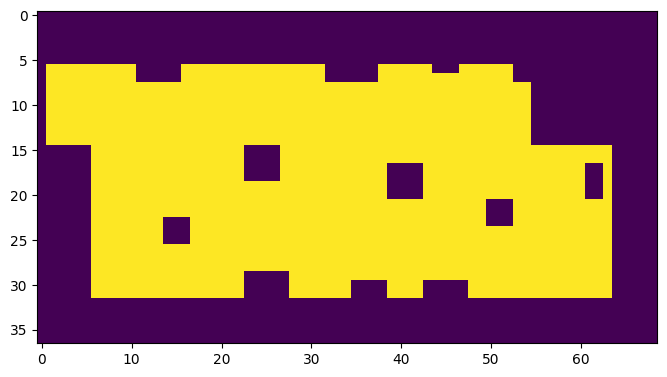

In [142]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(mask)

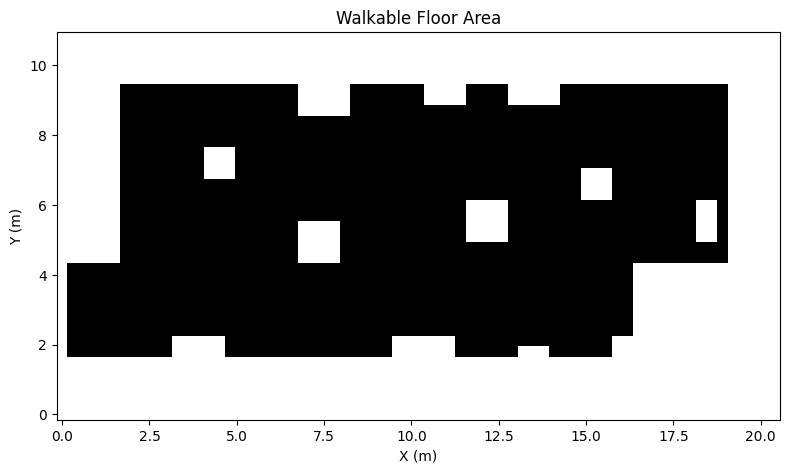

In [125]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(xg, yg, mask, cmap='Greys', shading='auto')
plt.gca().set_aspect('equal')
plt.title('Walkable Floor Area')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.tight_layout()
plt.show()

In [126]:
def discretize_walkable_area(mask, xg, yg):
    """
    Converts a walkable binary mask into discrete state grid.

    Parameters
    ----------
    mask : 2D np.array (bool)
        True where walkable.
    xg, yg : 2D np.array
        Meshgrid of X and Y coordinates (same shape as mask).

    Returns
    -------
    state_map : 2D np.array (int)
        Grid of same shape as mask: each walkable cell has a unique state ID,
        non-walkable cells are -1.
    state_lookup : dict[int, tuple[float, float]]
        Maps state ID to (x, y) coordinate center of that state.
    """
    state_map = -1 * np.ones_like(mask, dtype=int)  # default -1 = not walkable
    state_lookup = {}

    state_id = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                state_map[i, j] = state_id
                state_lookup[state_id] = (xg[i, j], yg[i, j])
                state_id += 1

    return state_map, state_lookup


In [127]:
state_map, state_lookup = discretize_walkable_area(mask, xg, yg)

In [153]:
state_lookup

{0: (np.float64(0.3), np.float64(1.7999999999999998)),
 1: (np.float64(0.6), np.float64(1.7999999999999998)),
 2: (np.float64(0.8999999999999999), np.float64(1.7999999999999998)),
 3: (np.float64(1.2), np.float64(1.7999999999999998)),
 4: (np.float64(1.5), np.float64(1.7999999999999998)),
 5: (np.float64(1.7999999999999998), np.float64(1.7999999999999998)),
 6: (np.float64(2.1), np.float64(1.7999999999999998)),
 7: (np.float64(2.4), np.float64(1.7999999999999998)),
 8: (np.float64(2.6999999999999997), np.float64(1.7999999999999998)),
 9: (np.float64(3.0), np.float64(1.7999999999999998)),
 10: (np.float64(4.8), np.float64(1.7999999999999998)),
 11: (np.float64(5.1), np.float64(1.7999999999999998)),
 12: (np.float64(5.3999999999999995), np.float64(1.7999999999999998)),
 13: (np.float64(5.7), np.float64(1.7999999999999998)),
 14: (np.float64(6.0), np.float64(1.7999999999999998)),
 15: (np.float64(6.3), np.float64(1.7999999999999998)),
 16: (np.float64(6.6), np.float64(1.7999999999999998))

In [154]:
state_lookup_03 = state_lookup

In [155]:
%store state_lookup_03

Stored 'state_lookup_03' (dict)


In [146]:
mask[15]

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False])

In [147]:
museum_mask_03m = mask

In [148]:
%store museum_mask_03m

Stored 'museum_mask_03m' (ndarray)


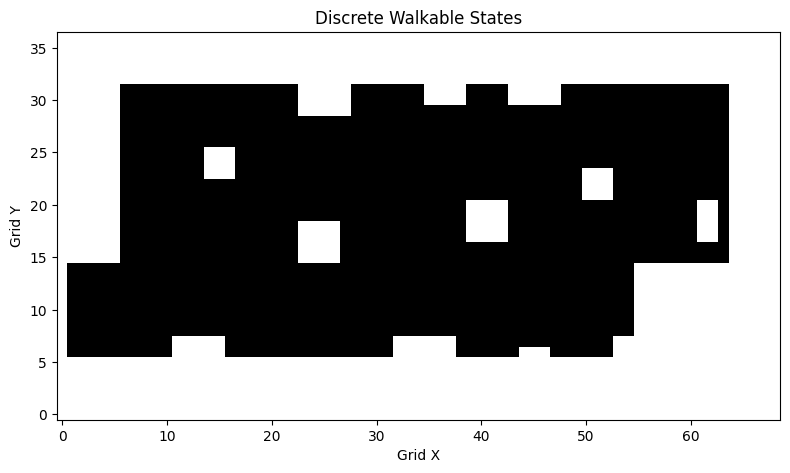

In [128]:
plt.figure(figsize=(8, 6))
plt.imshow(state_map >= 0, cmap='Greys', origin='lower')
plt.title("Discrete Walkable States")
plt.xlabel("Grid X")
plt.ylabel("Grid Y")
plt.tight_layout()
plt.show()


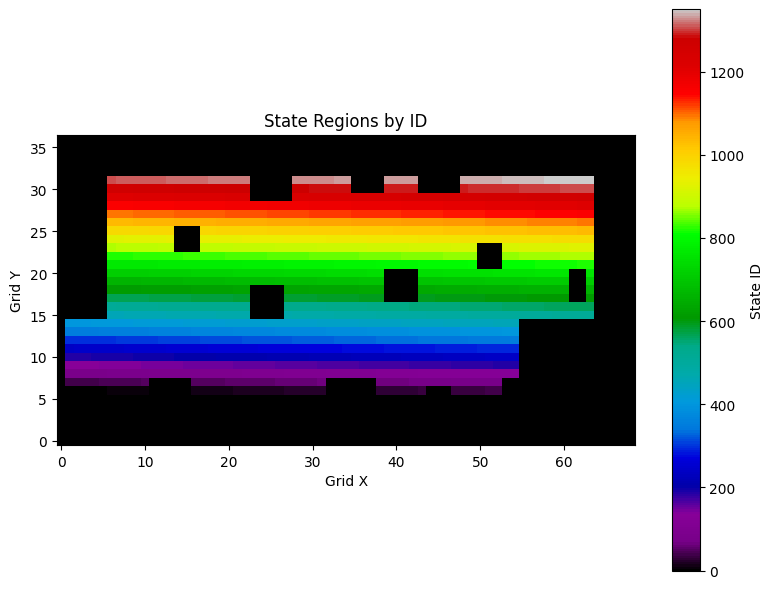

In [129]:
plt.figure(figsize=(8, 6))
plt.imshow(state_map, cmap='nipy_spectral', origin='lower', interpolation='none')
plt.colorbar(label='State ID')
plt.title("State Regions by ID")
plt.xlabel("Grid X")
plt.ylabel("Grid Y")
# plt.xlim(5, 10)  # meters
# plt.ylim(2, 10)   # meters
plt.tight_layout()
plt.show()

double check spaces above walls are not recognized as states

In [75]:
# T = pd.read_csv('drop_model_movement/floor_overlay_labels.csv')
# north_wall = T[T['name'] == 'wall_north'].iloc[0]

# x_north = north_wall['x'] * pix_to_m
# y_north = north_wall['y'] * pix_to_m
# w_north = north_wall['width'] * pix_to_m
# h_north = north_wall['height'] * pix_to_m

# print("North wall bounds:")
# print(f"x ∈ [{x_north:.2f}, {x_north + w_north:.2f}]")
# print(f"y ∈ [{y_north:.2f}, {y_north + h_north:.2f}]")

North wall bounds:
x ∈ [0.00, 15.90]
y ∈ [9.53, 11.10]


In [76]:
# for sid, (x, y) in state_lookup.items():
#     inside_x = (x >= x_north) and (x <= x_north + w_north)
#     inside_y = (y >= y_north) and (y <= y_north + h_north)
#     if inside_x and inside_y:
#         print(f"⚠️  State {sid} is inside the north wall at ({x:.2f}, {y:.2f})")

In [77]:
valid_state_ids = state_map[state_map >= 0]


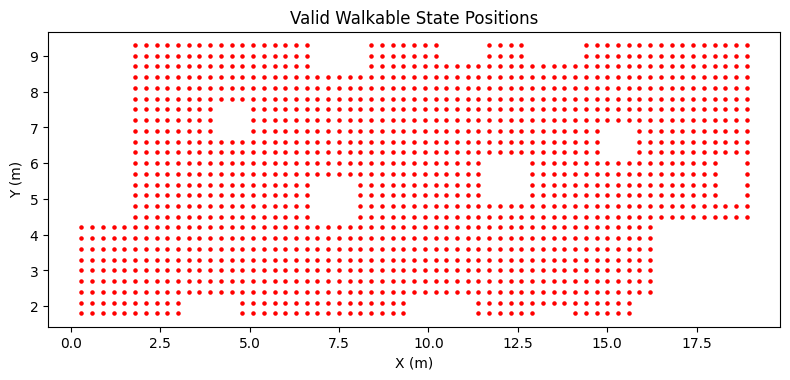

In [130]:
xs = [x for sid, (x, y) in state_lookup.items()]
ys = [y for sid, (x, y) in state_lookup.items()]

plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c='red', s=5)
plt.gca().set_aspect('equal')
plt.title("Valid Walkable State Positions")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.tight_layout()
plt.show()

# view of traces in new discretized state space

In [131]:
def get_state_for_position(x, y, x_grid, y_grid, state_map):
    """
    Maps a continuous (x, y) position to its corresponding discrete state ID.
    Returns -1 if out of bounds or non-walkable.
    """
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]

    col = int((x - x_grid[0, 0]) // dx)
    row = int((y - y_grid[0, 0]) // dy)

    if 0 <= row < state_map.shape[0] and 0 <= col < state_map.shape[1]:
        return state_map[row, col]
    return -1  # out of bounds or non-walkable


def map_trajectory_to_states(x_vals, y_vals, x_grid, y_grid, state_map):
    """
    Maps a full trajectory of (x_vals, y_vals) to a list of discrete state IDs.
    """
    return [get_state_for_position(x, y, x_grid, y_grid, state_map)
            for x, y in zip(x_vals, y_vals)]

In [132]:
# Load one cluster trace
data = pd.read_csv('drop_model_movement/cluster_007.csv', header=None)
x_traj = data.iloc[:, 1] * pix_to_m
y_traj = data.iloc[:, 2] * pix_to_m

# Map to states
state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

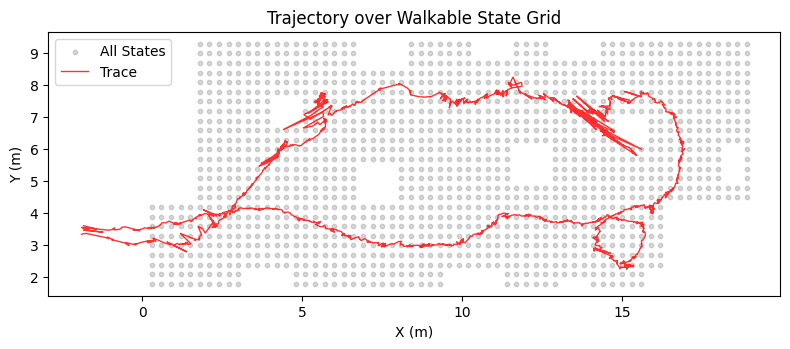

In [133]:
xs = [x for sid, (x, y) in state_lookup.items()]
ys = [y for sid, (x, y) in state_lookup.items()]

plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, s=10, alpha=0.3, color='gray', label='All States')
plt.plot(x_traj, y_traj, '-', color='red', linewidth=1.0, alpha=0.8, label='Trace')
plt.gca().set_aspect('equal')
plt.legend()
plt.title("Trajectory over Walkable State Grid")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.tight_layout()
plt.show()

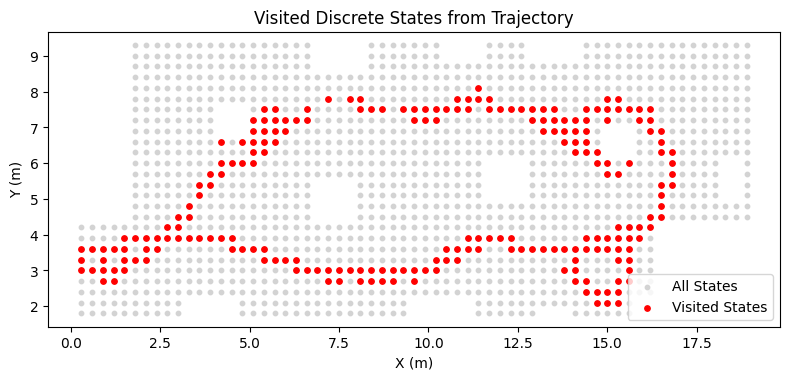

In [134]:
# Step 1: Unique visited state IDs (filtering out -1s)
visited_state_ids = set(sid for sid in state_trace if sid >= 0)

# Step 2: Look up positions of these states
visited_xs = [state_lookup[sid][0] for sid in visited_state_ids]
visited_ys = [state_lookup[sid][1] for sid in visited_state_ids]

# Step 3: Plot
plt.figure(figsize=(8, 6))

# Background: all states (gray)
all_xs = [x for sid, (x, y) in state_lookup.items()]
all_ys = [y for sid, (x, y) in state_lookup.items()]
plt.scatter(all_xs, all_ys, c='lightgray', s=10, label='All States')

# Highlight: visited states (red)
plt.scatter(visited_xs, visited_ys, c='red', s=15, label='Visited States')

plt.gca().set_aspect('equal')
plt.title("Visited Discrete States from Trajectory")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.tight_layout()
plt.show()


# descrete action table for a single trace

In [135]:
# Initialize counts
state_action_counts = defaultdict(lambda: np.zeros(5, dtype=int))  # 5 actions

# Go through the trajectory
for i in range(len(state_trace) - 1):
    s0 = state_trace[i]
    s1 = state_trace[i + 1]

    if s0 == -1 or s1 == -1:
        continue  # skip invalid transitions

    x0, y0 = state_lookup[s0]
    x1, y1 = state_lookup[s1]

    dx = round(x1 - x0, 6)
    dy = round(y1 - y0, 6)

    # Match movement to action
    if dx == 0 and dy == 0:
        action = 0  # stay
    elif dx == 0 and dy > 0:
        action = 1  # up
    elif dx == 0 and dy < 0:
        action = 2  # down
    elif dy == 0 and dx < 0:
        action = 3  # left
    elif dy == 0 and dx > 0:
        action = 4  # right
    else:
        continue  # ignore diagonal or invalid steps

    state_action_counts[s0][action] += 1

# Build table
unique_states = sorted(state_action_counts.keys())
action_labels = ['stay', 'up', 'down', 'left', 'right']

data = []
for state in unique_states:
    total = state_action_counts[state].sum()
    if total > 0:
        probs = state_action_counts[state] / total
    else:
        probs = np.zeros(5)
    data.append(probs)

# Convert to DataFrame for readability
action_df = pd.DataFrame(data, index=unique_states, columns=action_labels)
action_df.index.name = 'state_id'


In [136]:
action_df

,stay,up,down,left,right
state_id,,,,,
75,0.888889,0.000000,0.000000,0.000000,0.111111
76,0.989114,0.009331,0.000000,0.000000,0.001555
77,0.900000,0.000000,0.000000,0.100000,0.000000
126,0.777778,0.000000,0.000000,0.000000,0.222222
127,0.885714,0.000000,0.028571,0.057143,0.028571
...,...,...,...,...,...
1058,0.714286,0.000000,0.285714,0.000000,0.000000
1067,0.142857,0.000000,0.428571,0.000000,0.428571
1068,0.886364,0.000000,0.079545,0.022727,0.011364


# introduce a Reward Structure For State Space 

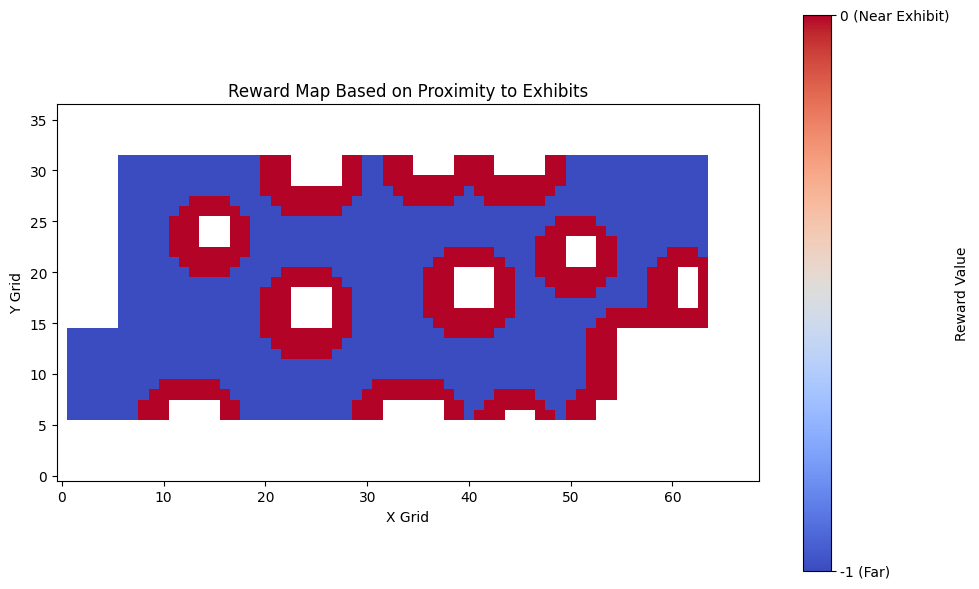

In [110]:
from scipy.ndimage import binary_dilation


# Parameters
resolution = 0.3
csv_path = 'drop_model_movement/floor_overlay_labels.csv'

# Step 1: Load and identify exhibit locations
T = pd.read_csv(csv_path)
exhibit_mask = np.zeros_like(mask, dtype=bool)

for _, row in T.iterrows():
    if 'exh' in str(row['name']).lower():  # Adjust to your column name
        x_start = int(row['x'] * 0.003175 // resolution)
        x_end = int((row['x'] + row['width']) * 0.003175 // resolution)
        y_start = int(row['y'] * 0.003175 // resolution)
        y_end = int((row['y'] + row['height']) * 0.003175 // resolution)
        exhibit_mask[y_start:y_end+1, x_start:x_end+1] = True

# Step 2: Dilate to define "nearby" region (e.g., within 2 cells)
near_exhibit_mask = binary_dilation(exhibit_mask, iterations=2)

# Step 3: Assign rewards
reward_grid = -np.ones_like(mask, dtype=int)
reward_grid[near_exhibit_mask & mask] = 0

# Step 4: Assign to state_lookup
state_rewards = {
    sid: reward_grid[np.where((xg == x) & (yg == y))][0]
    for sid, (x, y) in state_lookup.items()
}

# Step 5: Visualize
plt.figure(figsize=(10, 6))
plt.imshow(np.where(mask, reward_grid, np.nan), cmap='coolwarm', origin='lower')
cbar = plt.colorbar(ticks=[-1, 0])
cbar.ax.set_yticklabels(['-1 (Far)', '0 (Near Exhibit)'])
cbar.set_label('Reward Value')
plt.title("Reward Map Based on Proximity to Exhibits")
plt.xlabel("X Grid")
plt.ylabel("Y Grid")
plt.tight_layout()
plt.show()

In [149]:
reward_grid.shape

(37, 69)

In [151]:
reward_grid_03 = reward_grid

In [152]:
%store reward_grid_03

Stored 'reward_grid_03' (ndarray)


# create combined table for 3 probability traces 

In [137]:
# Initialize counts
state_action_counts = defaultdict(lambda: np.zeros(5, dtype=int))  # 5 actions

# Go through the trajectory
for i in range(len(state_trace) - 1):
    s0 = state_trace[i]
    s1 = state_trace[i + 1]

    if s0 == -1 or s1 == -1:
        continue  # skip invalid transitions

    x0, y0 = state_lookup[s0]
    x1, y1 = state_lookup[s1]

    dx = round(x1 - x0, 6)
    dy = round(y1 - y0, 6)

    # Match movement to action
    if dx == 0 and dy == 0:
        action = 0  # stay
    elif dx == 0 and dy > 0:
        action = 1  # up
    elif dx == 0 and dy < 0:
        action = 2  # down
    elif dy == 0 and dx < 0:
        action = 3  # left
    elif dy == 0 and dx > 0:
        action = 4  # right
    else:
        continue  # ignore diagonal or invalid steps

    state_action_counts[s0][action] += 1

# Build table
unique_states = sorted(state_action_counts.keys())
action_labels = ['stay', 'up', 'down', 'left', 'right']

data = []
for state in unique_states:
    total = state_action_counts[state].sum()
    if total > 0:
        probs = state_action_counts[state] / total
    else:
        probs = np.zeros(5)
    data.append(probs)

# Convert to DataFrame for readability
action_df = pd.DataFrame(data, index=unique_states, columns=action_labels)
action_df.index.name = 'state_id'


In [138]:


# Files to include
file_list = [
    'drop_model_movement/cluster_001.csv',
    'drop_model_movement/cluster_002.csv',
    'drop_model_movement/cluster_009.csv'
]

# Initialize combined action count dictionary
state_action_counts = defaultdict(lambda: np.zeros(5, dtype=int))  # 5 actions

# Process each file
for file_path in file_list:
    data = pd.read_csv(file_path, header=None)
    x_traj = data.iloc[:, 1] * pix_to_m
    y_traj = data.iloc[:, 2] * pix_to_m

    # Map trajectory to states
    state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

    # Accumulate action counts
    for i in range(len(state_trace) - 1):
        s0 = state_trace[i]
        s1 = state_trace[i + 1]

        if s0 == -1 or s1 == -1:
            continue  # skip invalid transitions

        if s0 not in state_lookup or s1 not in state_lookup:
            continue  # avoid KeyError

        x0, y0 = state_lookup[s0]
        x1, y1 = state_lookup[s1]

        dx = round(x1 - x0, 6)
        dy = round(y1 - y0, 6)

        # Determine action
        if dx == 0 and dy == 0:
            action = 0  # stay
        elif dx == 0 and dy > 0:
            action = 1  # up
        elif dx == 0 and dy < 0:
            action = 2  # down
        elif dy == 0 and dx < 0:
            action = 3  # left
        elif dy == 0 and dx > 0:
            action = 4  # right
        else:
            continue  # ignore diagonal or strange transitions

        state_action_counts[s0][action] += 1

# Build final probability table
unique_states = sorted(state_action_counts.keys())
action_labels = ['stay', 'up', 'down', 'left', 'right']

data = []
for state in unique_states:
    total = state_action_counts[state].sum()
    if total > 0:
        probs = state_action_counts[state] / total
    else:
        probs = np.zeros(5)
    data.append(probs)

action_df_h = pd.DataFrame(data, index=unique_states, columns=action_labels)
action_df_h.index.name = 'state_id'

# Show or export
# print(action_df.head())


In [140]:
action_df_h

,stay,up,down,left,right
state_id,,,,,
0,0.800000,0.200000,0.000000,0.000000,0.000000
8,0.941176,0.058824,0.000000,0.000000,0.000000
32,0.500000,0.500000,0.000000,0.000000,0.000000
35,0.000000,1.000000,0.000000,0.000000,0.000000
38,0.529412,0.117647,0.117647,0.000000,0.235294
...,...,...,...,...,...
1345,0.000000,0.000000,0.333333,0.666667,0.000000
1347,0.750000,0.000000,0.250000,0.000000,0.000000
1348,0.809581,0.000000,0.143713,0.000000,0.046707


In [ ]:
# figure out how state ids are associated with each other
